# Sequence to Sequence Learning with Neural Networks

In this task, we will use a sequence to sequence model for machine translation.
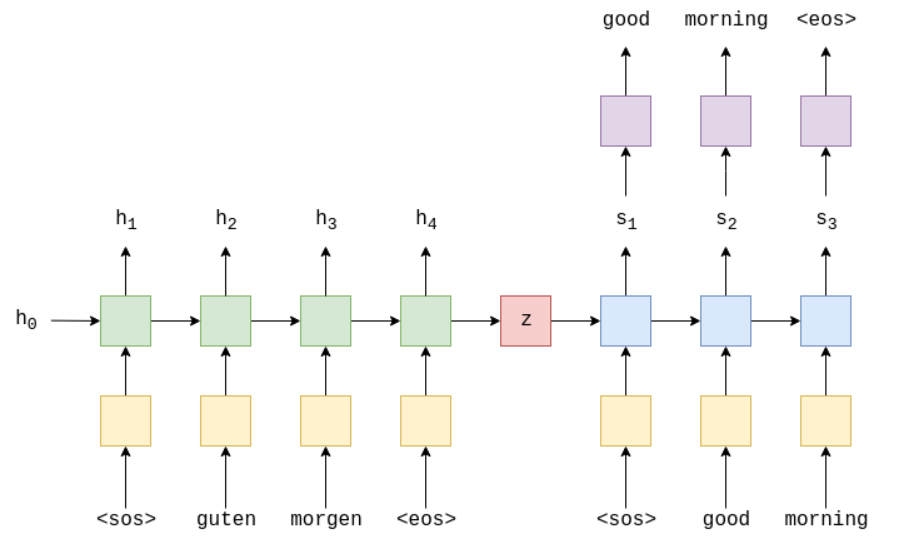![](assets/seq2seq1.png)


## Preparing Data
We'll be coding up the models in PyTorch and using torchtext to help us do all of the pre-processing required. We'll also be using spaCy to assist in the tokenization of the data.

In [6]:
!pip install portalocker

In [7]:
import torch
from torch.utils.data import DataLoader
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.utils import get_tokenizer
from torchtext.datasets import multi30k, Multi30k
from torch.nn.utils.rnn import pad_sequence
import spacy
import random
import numpy as np
import math
import time

In [8]:
import torch.nn as nn
import torch.optim as optim


In [9]:
# Update URLs to point to data stored by user
multi30k.URL["train"] = "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/training.tar.gz"
multi30k.URL["valid"] = "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/validation.tar.gz"
multi30k.URL["test"] = "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/mmt_task1_test2016.tar.gz"

# Update hash since there is a discrepancy between user hosted test split and that of the test split in the original dataset
multi30k.MD5["test"] = "876a95a689a2a20b243666951149fd42d9bfd57cbbf8cd2c79d3465451564dd2"

In [10]:
# set the random seed
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

Next, we'll create the tokenizers. A tokenizer is used to turn a string containing a sentence into a list of individual tokens that make up that string, e.g. "good morning!" becomes ["good", "morning", "!"].

Using these two pips to install spacy tokenizer model for English and German language
After installing, you need restart to find the installed package.

In [11]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [12]:
!pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.0.0/en_core_web_sm-3.0.0.tar.gz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 55.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [13]:
!pip install https://github.com/explosion/spacy-models/releases/download/de_core_news_sm-3.0.0/de_core_news_sm-3.0.0.tar.gz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.3/19.3 MB 64.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [14]:
spacy_de = spacy.load('de_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')

/usr/local/lib/python3.10/dist-packages/torch/__init__.py:696: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)


In [15]:
def tokenize_de(text):
    """Tokenizes German text from a string into a list of strings (tokens)"""
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    """Tokenizes English text from a string into a list of strings (tokens)"""
    return [tok.text for tok in spacy_en.tokenizer(text)]


In [16]:
def yield_tokens(data_iter, language):
    for data in data_iter:
        if language == 'de':
            yield tokenize_de(data[0])
        else:
            yield tokenize_en(data[1])


In [17]:
# Building vocabularies
def build_vocab(data_iter, language):
    # tokenizer = tokenize_de if language == 'de' else tokenize_en
    return build_vocab_from_iterator(yield_tokens(data_iter, language), min_freq = 2, specials=['<unk>', '<pad>', '<sos>', '<eos>'])


In [18]:
# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the dataset
train_data, valid_data, test_data = Multi30k(split=('train', 'valid', 'test'))

Next, we download and load the train, validation and test data.

The dataset we'll be using is the [Multi30k dataset](https://github.com/multi30k/dataset). This is a dataset with ~30,000 parallel English, German and French sentences, each with ~12 words per sentence.

`exts` specifies which languages to use as the source and target (source goes first) and `fields` specifies which field to use for the source and target.

In [49]:
# Build vocabularies
# train_iter = Multi30k(split='train')
src_vocab = build_vocab(train_data, 'de')
trg_vocab = build_vocab(train_data, 'en')

# Set special tokens
src_vocab.set_default_index(src_vocab['<unk>'])
trg_vocab.set_default_index(trg_vocab['<unk>'])


/usr/local/lib/python3.10/dist-packages/torch/utils/data/datapipes/iter/combining.py:337: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "


In [50]:
len(src_vocab.vocab), len(trg_vocab.vocab)

(8014, 6191)

In [51]:
for line in train_data:
    print(line)
    break

('Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.', 'Two young, White males are outside near many bushes.')


We have:  
train: 29000;
valid: 1014;
test: 1000

The period is at the beginning of the German (src) sentence, so it looks like the sentence has been correctly reversed.

Next, we'll build the *vocabulary* for the source and target languages. The vocabulary is used to associate each unique token with an index (an integer). The vocabularies of the source and target languages are distinct.

Using the `min_freq` argument, we only allow tokens that appear at least 2 times to appear in our vocabulary. Tokens that appear only once are converted into an `<unk>` (unknown) token.

It is important to note that our vocabulary should only be built from the training set and not the validation/test set. This prevents "information leakage" into our model, giving us artifically inflated validation/test scores.

In [52]:
def collate_fn(batch):
    src_batch, trg_batch = [], []
    for src_sample, trg_sample in batch:

        src_batch.append(torch.tensor([src_vocab[token] for token in tokenize_de(src_sample)], dtype=torch.long))
        trg_batch.append(torch.tensor([trg_vocab[token] for token in tokenize_en(trg_sample)], dtype=torch.long))

    src_batch = pad_sequence(src_batch, padding_value=src_vocab['<pad>'])
    trg_batch = pad_sequence(trg_batch, padding_value=trg_vocab['<pad>'])
    return src_batch, trg_batch

In [53]:
BATCH_SIZE = 128
train_dataloader = DataLoader(list(train_data), batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
valid_dataloader = DataLoader(list(valid_data), batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
# test_dataloader = DataLoader(list(test_data), batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)


In [54]:

print(f"Number of training examples: {len(train_dataloader.dataset)}")
print(f"Number of validation examples: {len(valid_dataloader.dataset)}")
# print(f"Number of testing examples: {len(test_dataloader.dataset)}")

Number of training examples: 29001
Number of validation examples: 1015


## Building the Seq2Seq Model

### Encoder

In [55]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()

        self.hid_dim = hid_dim
        self.n_layers = n_layers

        self.embedding = nn.Embedding(input_dim, emb_dim)

        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)

        self.dropout = nn.Dropout(dropout)

    def forward(self, src):

        #src = [src len, batch size]

        embedded = self.dropout(self.embedding(src))

        #embedded = [src len, batch size, emb dim]

        outputs, (hidden, cell) = self.rnn(embedded)

        #outputs = [src len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]

        #outputs are always from the top hidden layer

        return hidden, cell

### Decoder

In [56]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()

        self.output_dim = output_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers

        self.embedding = nn.Embedding(output_dim, emb_dim)

        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)

        self.fc_out = nn.Linear(hid_dim, output_dim)

        self.dropout = nn.Dropout(dropout)

    # decoder starts fromt the last (hidden, cell) of the encoder
    def forward(self, input, hidden, cell):

        #input = [batch size]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]

        #n directions in the decoder will both always be 1, therefore:
        #hidden = [n layers, batch size, hid dim]
        #context = [n layers, batch size, hid dim]

        input = input.unsqueeze(0)

        #input = [1, batch size]

        embedded = self.dropout(self.embedding(input))

        #embedded = [1, batch size, emb dim]

        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))

        #output = [seq len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]

        #seq len and n directions will always be 1 in the decoder, therefore:
        #output = [1, batch size, hid dim]
        #hidden = [n layers, batch size, hid dim]
        #cell = [n layers, batch size, hid dim]

        prediction = self.fc_out(output.squeeze(0))

        #prediction = [batch size, output dim]

        return prediction, hidden, cell

### Sequence to sequence model

In [57]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.device = device

        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"

    def forward(self, src, trg):

        #src = [src len, batch size]
        #trg = [trg len, batch size]

        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim

        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)

        #last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = self.encoder(src)

        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        for t in range(1, trg_len):

            #insert input token embedding, previous hidden and previous cell states
            #receive output tensor (predictions) and new hidden and cell states
            output, hidden, cell = self.decoder(input, hidden, cell)

            #place predictions in a tensor holding predictions for each token
            outputs[t] = output

            #conditioned on the previous actual token
            input = trg[t]

        return outputs

### Training the Seq2Seq Model

In [58]:
! nvidia-smi

Wed Mar 27 05:57:46 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0              39W / 300W |    508MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [59]:
# import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('device', device)
INPUT_DIM = len(src_vocab.vocab)
OUTPUT_DIM = len(trg_vocab.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

model = Seq2Seq(enc, dec, device).to(device)

device cuda


In [60]:
# define optimizer
optimizer = optim.Adam(model.parameters())

Next, we define our loss function. The `CrossEntropyLoss` function calculates both the log softmax as well as the negative log-likelihood of our predictions.

Our loss function calculates the average loss per token, however by passing the index of the `<pad>` token as the `ignore_index` argument we ignore the loss whenever the target token is a padding token.

In [61]:
TRG_PAD_IDX = trg_vocab['<pad>']

# criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

Training Loop

In [62]:
def train(model, iterator, optimizer, criterion, clip):

    model.train()

    epoch_loss = 0

    for i, (src, trg) in enumerate(iterator):

        src = src.to(device)
        trg = trg.to(device)



        optimizer.zero_grad()

        output = model(src, trg)

        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]

        output_dim = output.shape[-1]

        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)

        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]

        loss = criterion(output, trg)

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(iterator)

Evaluation Loop without parameter update

In [63]:
def evaluate(model, iterator, criterion):

    model.eval()

    epoch_loss = 0

    with torch.no_grad():

        for i, (src, trg) in enumerate(iterator):

            src = src.to(device)
            trg = trg.to(device)



            output = model(src, trg)

            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]

            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)

            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

Start training the model!

In [64]:
N_EPOCHS = 2
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss = train(model, train_dataloader, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_dataloader, criterion)

    end_time = time.time()


    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')

    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

	Train Loss: 5.250 | Train PPL: 190.563
	 Val. Loss: 4.414 |  Val. PPL:  82.634
	Train Loss: 4.303 | Train PPL:  73.934
	 Val. Loss: 3.949 |  Val. PPL:  51.859


## Load the trained model to evaluate

In [ ]:
# model.load_state_dict(torch.load('tut1-model.pt'))

# test_loss = evaluate(model, test_iterator, criterion)

# print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')